# Customer churn forecast for a chain of fitness centers

The fitness center chain wants to change its customer policy to reduce churn.

Purpose of the study:
1. learn to predict the probability of outflow (at the level of the next month) for each client;
2. form typical client portraits: identify several of the most striking groups and characterize their main properties;
3. analyze the main features that most strongly affect the outflow;
4. formulate the main conclusions and develop recommendations for improving the quality of work with clients.

Available data: customer data for a month before the churn and the fact of the churn.

Work plan:
1. Familiarization and pre-processing of data.
2. Exploratory data analysis.
3. Preparing a churn forecasting model.
4. Client clustering.
5. Conclusions and recommendations based on the results of the study.

## Acquaintance and pre-processing of data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from plotly import graph_objects as go

In [2]:
!pip -q install --upgrade sklearn

In [3]:
!pip install --upgrade seaborn --user

     |████████████████████████████████| 292 kB 1.7 MB/s eta 0:00:01


In [4]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [5]:
data.sample(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1264,1,1,0,0,1,1,1,29,71.523522,1.0,1,2.729743,2.753885,0
905,1,1,1,1,1,6,1,32,90.242379,6.0,21,1.336809,1.384730,0
2437,1,1,1,0,1,1,0,32,8.039850,1.0,0,1.183160,0.088125,1
1502,1,1,1,0,1,1,1,30,50.813166,1.0,6,3.867089,3.871257,0
771,1,1,1,0,1,12,1,31,63.486831,12.0,2,2.756225,2.807976,0
1337,1,1,0,1,1,12,1,24,202.390508,12.0,1,0.999179,1.047047,0
574,0,1,0,0,1,1,1,36,347.177762,1.0,7,1.846222,1.914159,0
1766,1,1,0,0,1,1,1,33,311.724788,1.0,6,1.183611,1.013930,0
3339,0,1,0,0,1,1,1,29,141.867035,1.0,3,1.075681,1.978230,1
1442,0,1,1,0,1,12,0,32,184.530753,11.0,3,2.336441,2.162144,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [8]:
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
data[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = \
data[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype('bool')

In [11]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   bool   
 1   near_location                      4000 non-null   bool   
 2   partner                            4000 non-null   bool   
 3   promo_friends                      4000 non-null   bool   
 4   phone                              4000 non-null   bool   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   bool   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

We have data on the characteristics of fitness center customers, as well as data on their purchases and actions. There are no duplicates or omissions. The column names have been converted to inline form. Data type has been changed for some columns

## Exploratory data analysis

In [12]:
data.describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


The data is distributed close to evenly, the standard deviations are not too far from the mean (except for avg_additional_charges_total - total revenue from other goods sold). 

In [13]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
False,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
True,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Consider the average values ​​in 2 groups - those who left and those who stayed:
1. "gender" (gender) - the average is the same, this indicates that, which means that the trait does not affect the outflow / inflow.
2. "near_location" (living or working nearby) - a fairly high figure in both groups, which means that most of the clients are probably those who live and work nearby. And customer churn is greater among those who are farther from the fitness center. We can say that this feature has little effect on the outflow.
3. "partner" (an employee of the partner's company) - Among partners, the outflow is less, however, the attribute does not affect so much.
4. "promo_friends" (first entry as refer a friend) - The impact on customers is positive, but weak.
5. "phone" - those who left the phone in the questionnaire will not be suitable for future analysis.
6. "contract_period" (subscription duration) - a significant positive impact of the feature on customers.
7. "group_visits" (visiting group classes) - also has a positive effect, but less strong.
8. "age" (age) - has a weak positive impact on customers.
9. "avg_additional_charges_total" (revenue from other services and goods) - has a weak positive impact.
10. "month_to_end_contract" (subscription expiration date in months) - the sign has a strong positive impact on customers.
11. "lifetime" (time since the first visit) - has a strong positive impact.
12. "avg_class_frequency_total" (average visit frequency per week for the entire subscription) - the attribute has a positive effect on customers.
13. "avg_class_frequency_current_month" (average frequency of visits per week for the previous month) - a positive impact on customers.

In [14]:
bool_features = [] 
count_features = []

for col in (data.columns.tolist()):
    if data[col].dtype == 'bool':
        bool_features.append(col)
    else:
        count_features.append(col)

In [15]:
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,11))
# axes_list = [item for sublist in axes for item in sublist]
# fig.tight_layout(pad=5.0)
# fig.suptitle('Распределение булевых признаков', fontsize=16)
# for feature in bool_features:
#     ax = axes_list.pop(0)
#     sns.distplot(data.query('churn == 1')[feature], bins=4, ax=ax, kde=False, color='blue',label='ушли (1)')
#     sns.distplot(data.query('churn == 0')[feature], bins=4, ax=ax, kde=False, color='green',label='остались (0)')
#     ax.set_xticks([0,1])
#     ax.set_xlabel(feature, fontsize=12)
#     ax.set_ylabel('Кол-во клиентов', fontsize=12)
#     ax.legend()

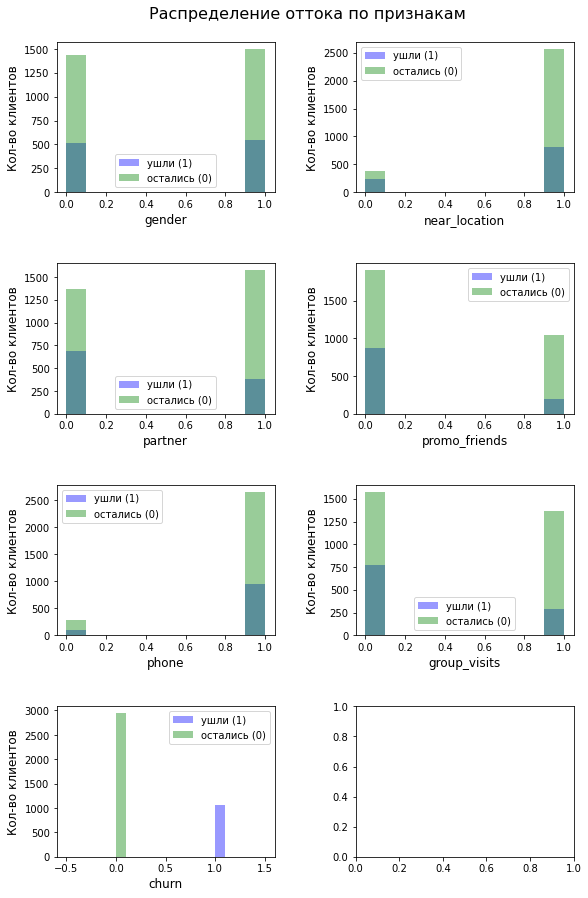

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9,13))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение оттока по признакам', fontsize=16)
for feature in bool_features:
    ax = axes_list.pop(0)
    sns.distplot(data.query('churn == 1')[feature], bins=10, ax=ax, kde=False, color='blue',label='ушли (1)')
    sns.distplot(data.query('churn == 0')[feature], bins=10, ax=ax, kde=False, color='green',label='остались (0)')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Кол-во клиентов', fontsize=12)
    ax.legend()

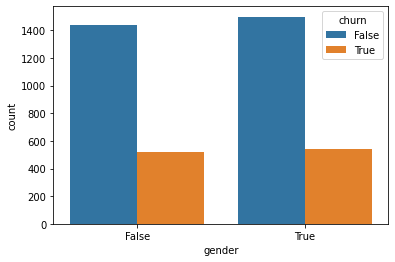

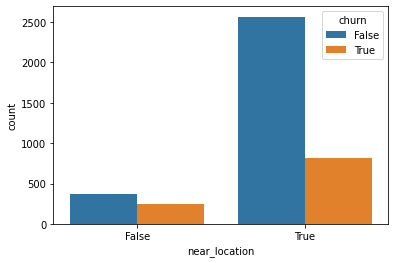

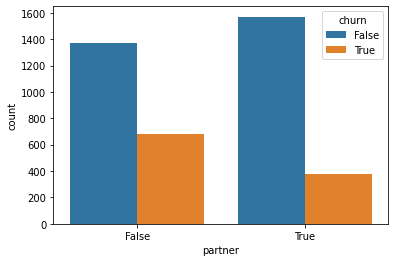

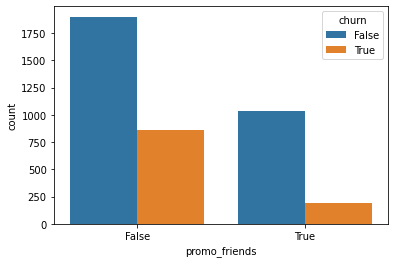

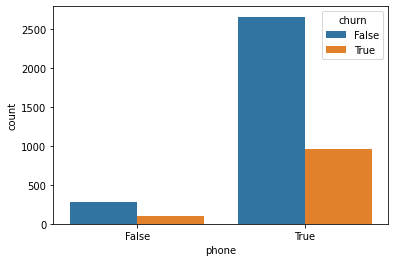

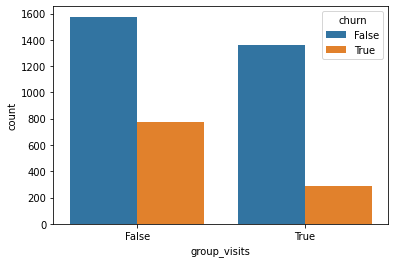

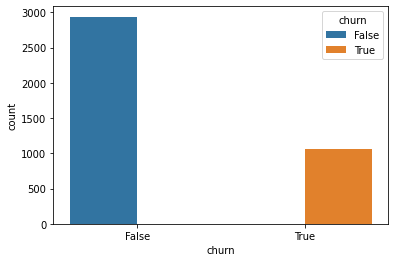

In [17]:
for i in bool_features:
    plt.figure(i)
    ax = sns.countplot(x= i, hue= "churn", data=data)

According to the graphs for boolean features, you can see that the ratio of male / female (gender) is approximately the same distribution, and the shares of the outflow are also equal. Among those who live closer to the fitness center (near_location), the proportion of those who remain is much larger. Those who participated in the affiliate program (partner) are slightly more than those who did not participate. And those who are a partner often stay and continue to walk. There are significantly fewer participants in the promo-action (promo-friends), but the proportion of those remaining among them is much larger. Most of the clients left their phone number in the questionnaire. Among those who went to group classes (group_visits), a larger number of clients remained.

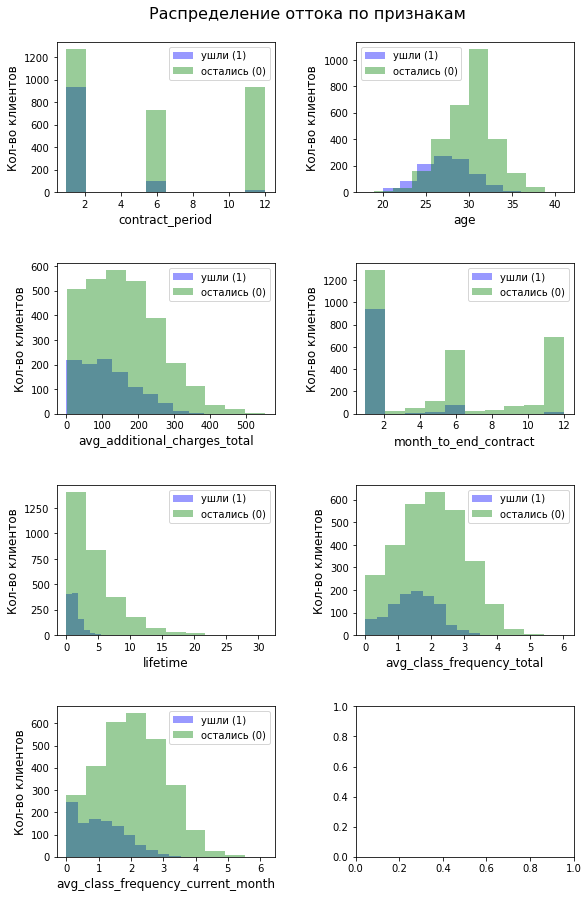

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9,13))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение оттока по признакам', fontsize=16)
for feature in count_features:
    ax = axes_list.pop(0)
    sns.distplot(data.query('churn == 1')[feature], bins=10, ax=ax, kde=False, color='blue',label='ушли (1)')
    sns.distplot(data.query('churn == 0')[feature], bins=10, ax=ax, kde=False, color='green',label='остались (0)')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Кол-во клиентов', fontsize=12)
    ax.legend()

Quantitatively, we see the following:
1. Contract duration (contract_period) - the main churn for customers with a contract for a month, among those with a long-term contract, the churn is much less.
2. Age (age) - the age category up to 27 years old is more likely to leave the fitness center than older people.
3. Revenue from other goods and services (avg_additional_charges_total) - the impact on the outflow is not pronounced, probably the relationship is weak.
4. The number of months until the end of the subscription (month_to_end_contract) - the more time left until the end of the subscription, the less likely the client is to churn. The main outflow is among those who have 1 month left.
5. Time since the first visit (lifetime) - among those who have a long "lifetime" there is almost no outflow.
6. Average visit frequency per week (avg_class_frequency_total) - for those who go up to 2 times a week, the churn shares are approximately the same, but if the client goes 3 or more times, then there is no churn at all, but there are much fewer such clients.
7. Average frequency of visits in the last month (avg_class_frequency_current_month) - among those who visit fitness more often in the last month, the churn rate is lower.

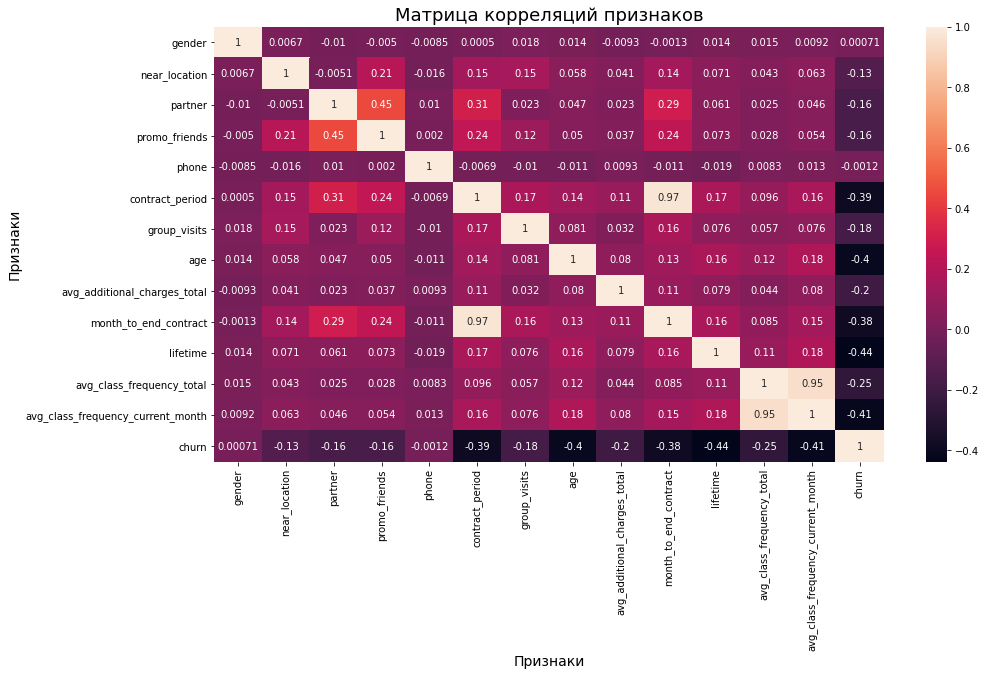

In [19]:
matr_corr = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(matr_corr, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 18)
plt.xlabel('Признаки', fontsize = 14) 
plt.ylabel('Признаки', fontsize = 14) 
plt.show()

According to the correlation matrix, we can say that all signs have a negative correlation for churn, which means that the stronger the sign, the weaker the outflow. Churn is most correlated with subscription duration (contract_period), age (age), contract duration (lifetime), and visit frequency in the last month (avg_class_frequency_current_month).
Nevertheless, the correlation is weak in all respects.

Gender (gender) and phone number (phone) - no effect of features on outflow, correlation is almost 0. Near_location, 'partner', 'promo_friends', 'group_visits', 'avg_additional_charges_total', 'avg_class_frequency_total'. The correlation in the range -(0.1-0.25) is very weak.

It should also be noted that there is a very strong (above 0.95) correlation of pairs of features (multicollinearity is possible), which will need to be taken into account in linear regression models:
a) 'contract_period' and 'month_to_end_contract' - the longer the subscription period, the more likely there are more months left;
b) 'avg_class_frequency_current_month' and 'avg_class_frequency_total' - those who have been walking with a regular schedule for a long time, most likely walked with the same schedule for the last month.

### Conclusion on exploratory data analysis
1. There are no significant outliers in the data.
2. All features have a negative correlation with the target variable (that is, the stronger the feature, the weaker the outflow of customers)
3. 5 features have a weak correlation with the target, the remaining features have a very weak or no correlation.
4. In 2 pairs of features, multicollinearity is likely.

## Churn Prediction Model
The forecasting model is binary, since the target feature is binary (churn/not churn).
The target feature is the fact that the client churns in the next month.

In [20]:
X = data.drop('churn', axis=1)
y = data['churn'] 

### Splitting the data into training and validation sets.
We divide the model into training and validation sets, apply standardization. The data is not tied to time, then you can apply "Random split".

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
display(X_train_st[:5])

X_test_st = scaler.transform(X_test) 

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.59173796,
         1.12734972,  1.75580418,  1.61822807],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378, -0.79568246,
         5.88138322, -0.2239674 , -0.01340886],
       [ 0.98511083,  0.4175068 ,  1.03175391, -0.67567125,  0.31628211,
         1.60502986, -0.84769226, -0.65650171, -1.18374157,  1.83048   ,
         0.3350108 , -0.84308456, -0.80541199],
       [-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         0.28610954, -0.84769226, -0.96548914, -0.95158829,  0.39802775,
         1.39146269,  0.66771379,  0.64605224],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125, -3.16173427,
        -0.81299073, -0.84769226, -0.03852687,  0.97190435, -0.79568246,
         0.07089783, -0.19587934, -0.16038147]])

### Models "Logistic regression" and "Random forest", calculation of metrics

In [22]:
def show_metrics(name, mdl):
    mdl.fit(X_train_st, y_train)
    y_pred = mdl.predict(X_test_st)
    print("Модель -", name)

    acc = accuracy_score(y_test, y_pred)
    print("Доля правильных ответов: Accuracy =",acc.round(3))
    precision = precision_score(y_test, y_pred).round(3)
    print("Точность: precision =", precision)
    recall = recall_score(y_test, y_pred).round(3)
    print("Полнота: recall =", recall, '\n')

model = LogisticRegression(random_state=0)
show_metrics('"Логистическая регрессия"', model)

model = RandomForestClassifier(n_estimators = 100, random_state=0)
show_metrics('"Случайный лес"', model)

Модель - "Логистическая регрессия"
Доля правильных ответов: Accuracy = 0.922
Точность: precision = 0.854
Полнота: recall = 0.828 

Модель - "Случайный лес"
Доля правильных ответов: Accuracy = 0.915
Точность: precision = 0.839
Полнота: recall = 0.813 



1. The Accuracy parameter for "Logistic Regression" is slightly higher (0.922, for "Random Forest" 0.915),
2. The Precision parameter also has a higher value for "Logistic Regression" (0.854, for "Random Forest" 0.839),
3. The Recall parameter is also slightly better for "Logistic Regression" (0.828, for "Random Forest" 0.813)
Thus, in all respects, "Logistic Regression" gives a slightly better result than "Random Forest". But both models have very high Accuracy (more than 0.91), precision and recall (in the range of 0.813 - 0.854), which means that the models are quite accurate.

## Client clustering

### Data standardization

In [23]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:3]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851]])

### Distance matrix, dendrogram

In [24]:
linkage = linkage(X_sc, method = 'ward')
linkage

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

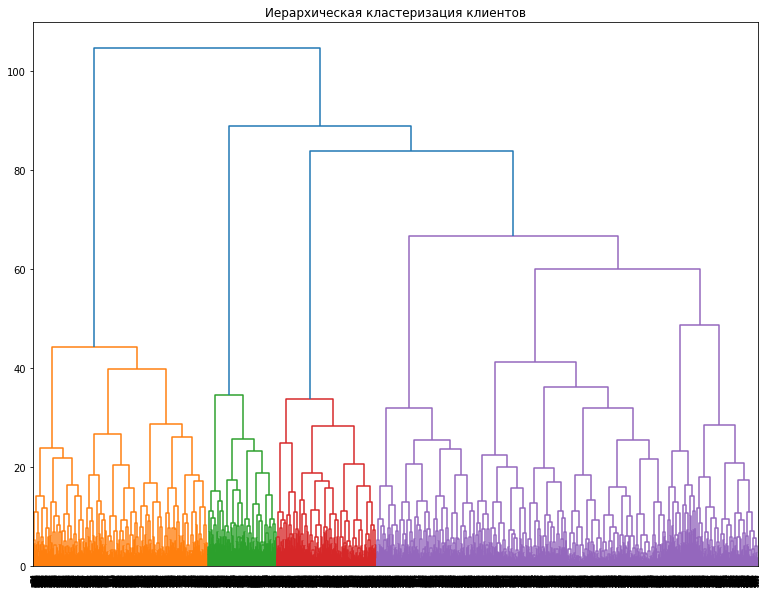

In [25]:
plt.figure(figsize=(13, 10))  
dendrogram(linkage, orientation='top')
plt.title('Иерархическая кластеризация клиентов')
plt.show()

Visually, you can select either 4 (by color) or 6 (by geometry) client clusters. 

### K-Means model of clasterisation

In [26]:
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc) 
labels

array([1, 0, 3, ..., 0, 0, 1], dtype=int32)

In [27]:
data['cluster'] = labels
data

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,True,True,True,True,False,6,True,29,14.227470,5,3,0.020398,0.000000,False,1
1,False,True,False,False,True,12,True,31,113.202938,12,7,1.922936,1.910244,False,0
2,False,True,True,False,True,1,False,28,129.448479,1,2,1.859098,1.736502,False,3
3,False,True,True,True,True,12,True,33,62.669863,12,2,3.205633,3.357215,False,0
4,True,True,True,True,True,1,False,26,198.362265,1,3,1.113884,1.120078,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,True,True,True,False,True,12,False,33,2.406023,12,8,2.284497,2.349070,False,0
3996,False,True,False,False,True,1,True,29,68.883764,1,1,1.277168,0.292859,True,3
3997,True,True,True,True,True,12,False,28,78.250542,11,2,2.786146,2.831439,False,0
3998,False,True,True,True,True,6,False,32,61.912657,5,3,1.630108,1.596237,False,0


In [28]:
data.groupby(['cluster'])['gender'].count()

cluster
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

There are large differences in the number of clients in different clusters (the largest is 3 - 1262, the smallest is 1 - 385).

In [29]:
data.drop('churn', axis=1).groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Let's single out features by clusters:

Cluster 0:
A high proportion of participants in the affiliate program (partner) - 78.3%,
The average share of participants in the promotion bring a friend (promo_friends) - 57.4%
Long subscription period (contract_period) - 11 months on average.
A large number of months until the end of the subscription (month_to_end_contract) - 10 months
Portrait of a client - they came through an affiliate program or a promotion, bought a subscription immediately for 1 year and have been going for a little 1-2 months so far. The dropout rate should be very low.

Cluster 1:
In this cluster, no one left a phone number in the questionnaire, and the rest of the features are not prominent.

Cluster 2:
Live far from the gym (near_location) = 0
Came not for a promotion or affiliate group, almost never use group classes (group_visits) = 21.6%

Cluster 3:
Average visit frequency low (avg_class_frequency_total) = 1.25, last month also (avg_class_frequency_current_month) = 1.01, likely to churn

Cluster 4:
The average visit frequency is very high (avg_class_frequency_total) = 2.85 and persists in the last month (avg_class_frequency_current_month) = 2.85. Athletes and fitness enthusiasts go frequently, and churn is expected to be minimal.

### Distribution of features by clusters

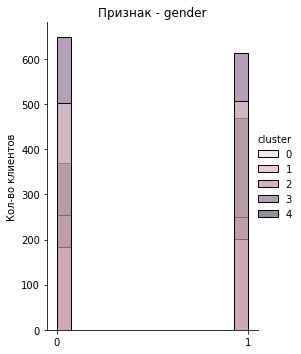

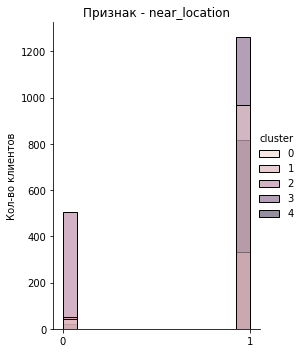

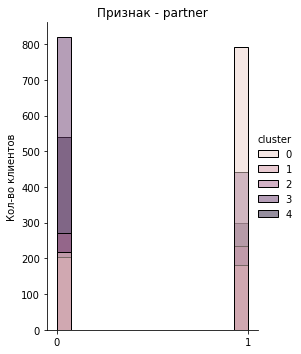

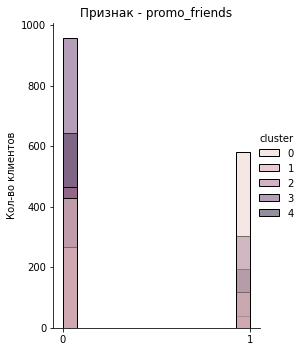

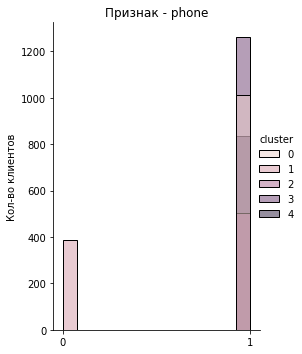

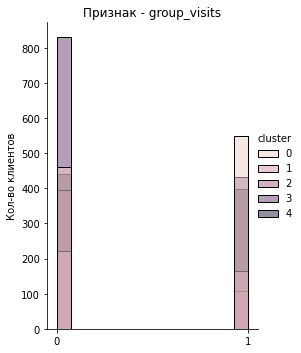

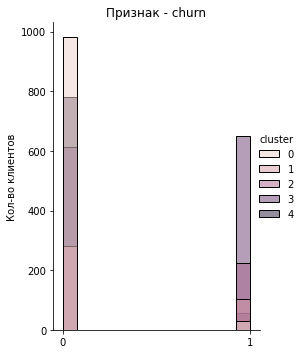

In [30]:
for f in bool_features:
    g = sns.displot(data, x=data[f], hue='cluster')
    plt.xticks([0, 1])
    plt.title(f'Признак - {f}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")
    g.fig.set_figwidth(4)
    g.fig.set_figheight(5)
    g.fig.patch.set_linewidth(5)

According to Boolean features, the following features of clusters can be distinguished:
1. Living nearby (near_location) - cluster "2" stands out strongly
2. Affiliate program (partner) - Cluster "3" - those who are not partners, Cluster "0" are.
3. Action bring a friend (promo_friends) - Clusters "1" and "3" - those who are not partners, Clusters "0" and "4" - are
4. Phone number (phone) - Cluster "1" - those who did not leave a phone number
5. Group lessons (group_visits) - Cluster "3" - attend group lessons less often. Cluster "0" - frequented.

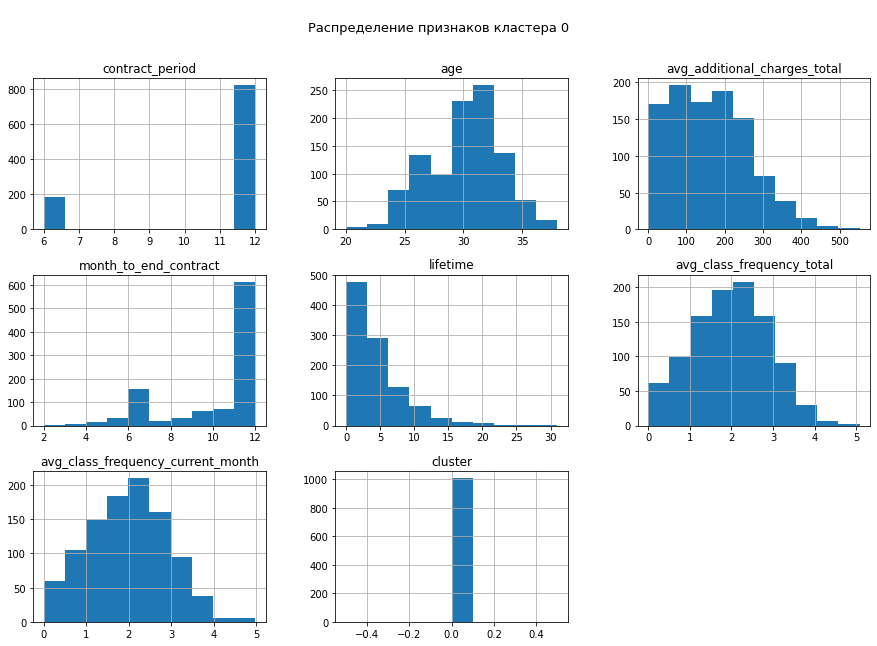

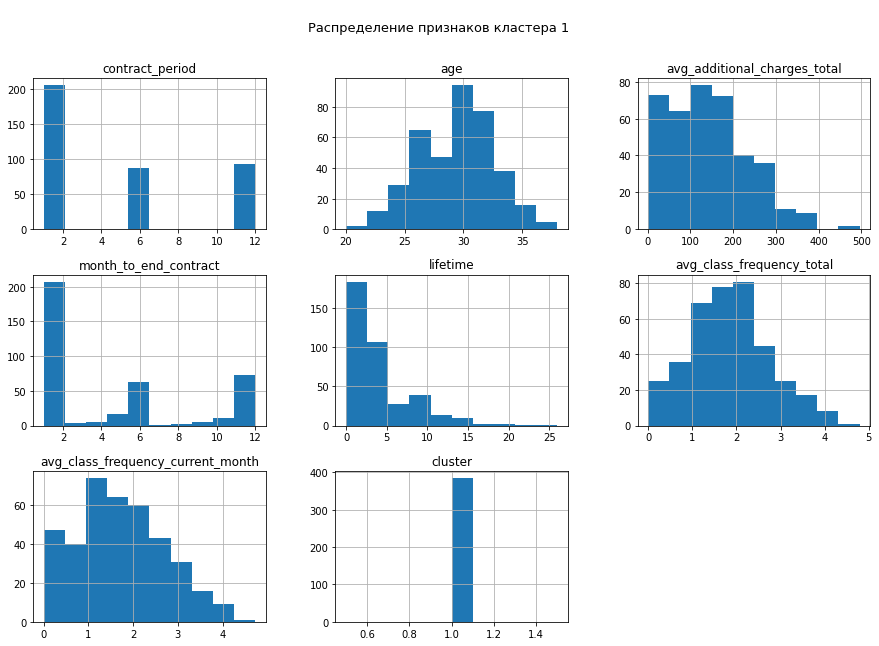

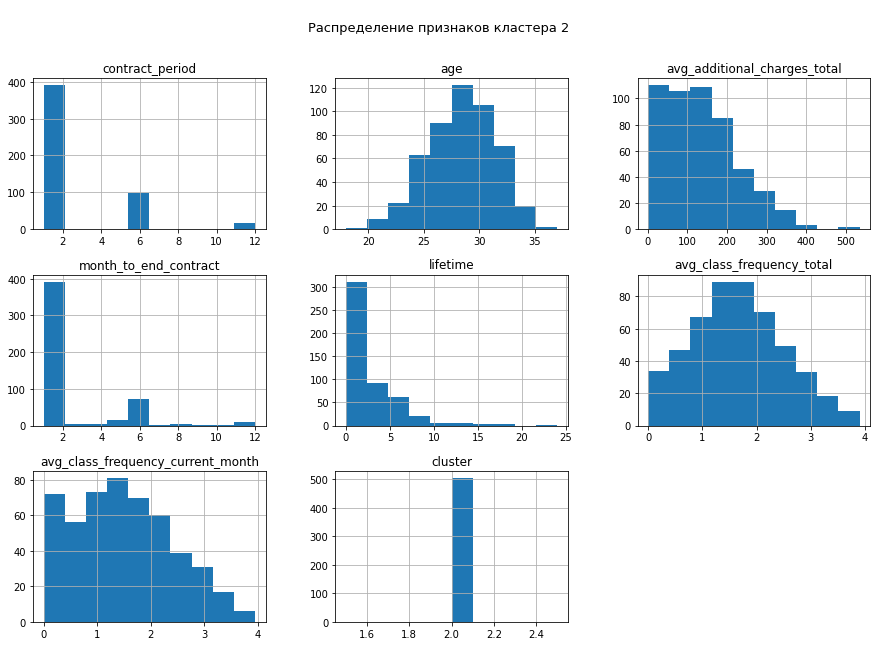

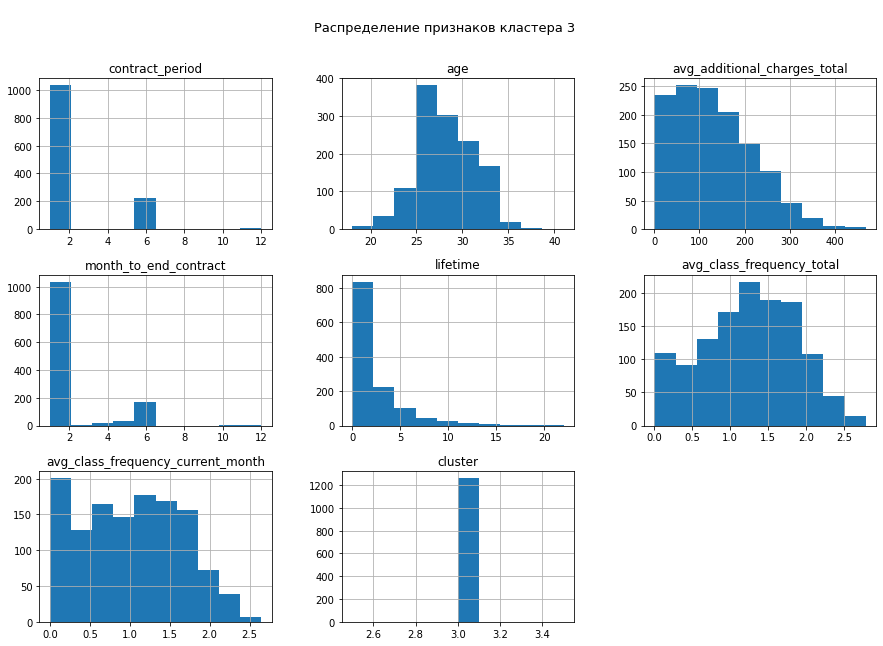

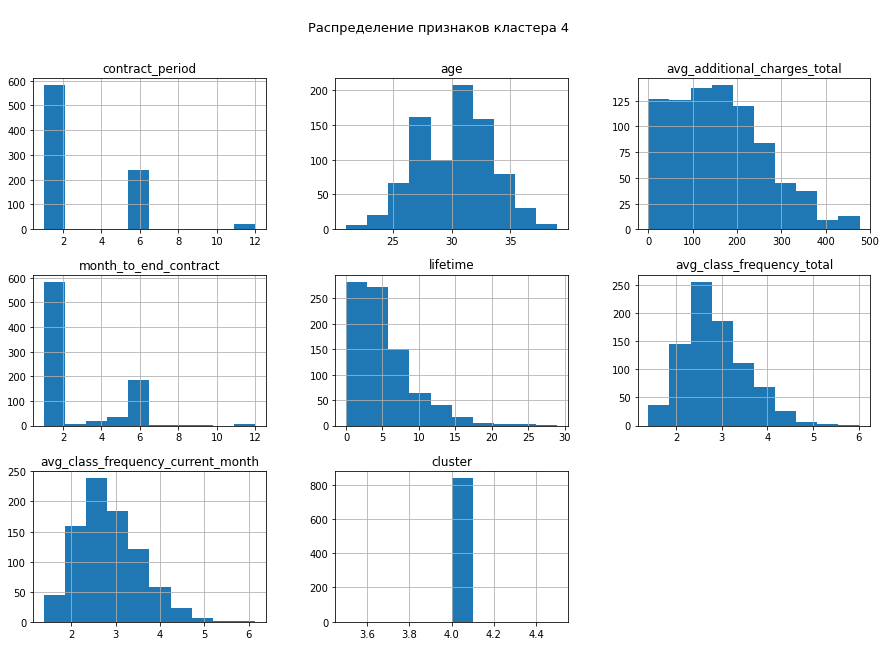

In [31]:
for value in [0, 1, 2, 3, 4]:
  data[data['cluster']==value].hist(figsize=(15,10))
  plt.suptitle('\nРаспределение признаков кластера {}'.format(value), fontsize = 13)
  plt.show()

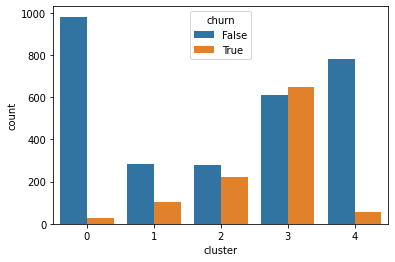

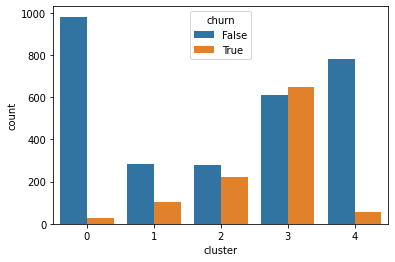

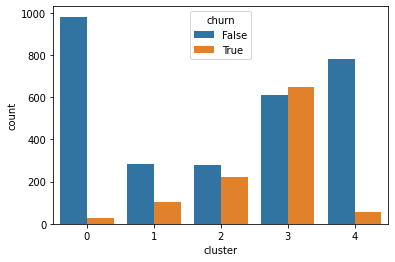

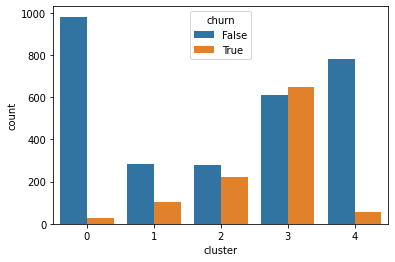

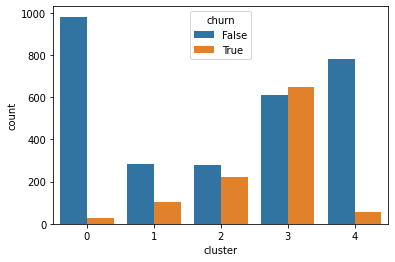

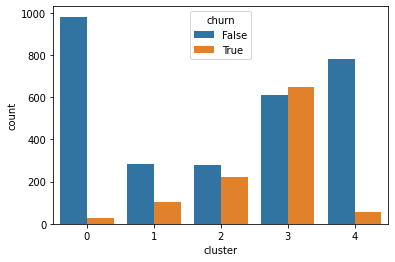

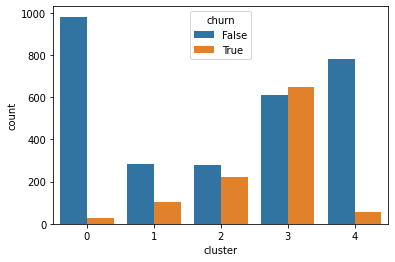

In [32]:
for i in bool_features:
    plt.figure(i)
    ax = sns.countplot(x= "cluster", hue= "churn", data=data)

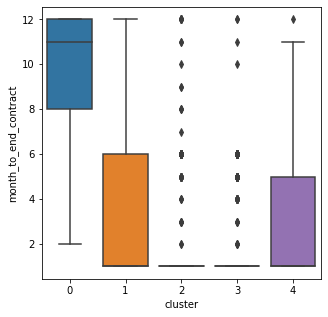

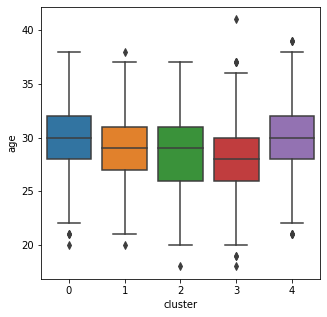

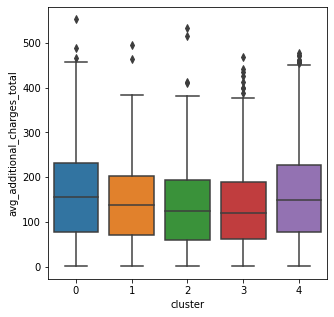

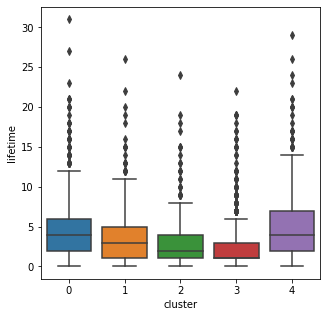

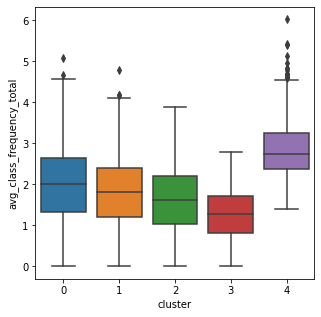

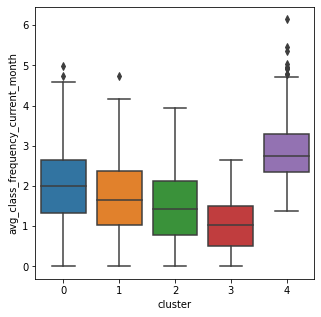

In [33]:
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster', y = data[column], data = data)
    plt.show()

According to quantitative features, the following features of clusters can be distinguished:

1. Subscription duration (contract_period) - subscriptions are sold for periods of 1,6,12 months. Cluster "0" consists mainly of annual subscriptions.
2. Age (age) - cluster "3" mainly consists of those who are 30 years old or younger, and those who are over 30 years old are included in cluster "0".
3. Revenue from other goods and services (avg_additional_charges_total) - cluster "3" spends less (because it's younger), cluster "0" spends more.
4. The number of months until the end of the subscription (month_to_end_contract) - cluster "0" is allocated - there are 6 months or more left.
5. The number of months since the beginning of the first visit (lifetime) - clusters 1 and 3 went less than 5 months, cluster "0" from 4 to 10 months.
6. Frequency of visits (avg_class_frequency_total) - Cluster "3" - those who go on average 1 time, cluster "0" - those who go 2-3 times, cluster "4" go 2 or more times.
7. Frequency of visits in the last month (avg_class_frequency_current_month) - similar to (avg_class_frequency_total).

### Shares of churn in clusters

In [34]:
outflow = data.query('churn==1').groupby('cluster')['churn'].count() / data.query('churn==1')['churn'].count()
outflow  

cluster
0    0.026390
1    0.097078
2    0.211122
3    0.611687
4    0.053723
Name: churn, dtype: float64

The maximum share of outflow in cluster "3" is 61.1%. The second place in terms of the share of outflow is cluster "2" - 21.1%, the third one is cluster "1" - 9.7%. The minimum outflow in the cluster is "4" and "0".

## Conclusions and recommendations for working with clients
The purpose of the study was to predict the outflow of clients, make their clustering and give recommendations on how to change the work with clients.

The data was processed, studied, 2 forecasting models were compiled, customer clusters were identified and their characteristic features were determined.

In this way:
1. When building models for predicting the outflow of customers, the models "Logistic regression" and "Random forest" were used. Both models showed high results - Accuracy (more than 0.91), precision and recall (in the range of 0.813 - 0.854), but in all respects "Logistic regression" gives a slightly better result.

2. As a result of the analysis, it was decided to divide the clients into 5 clusters, the characteristics of the clusters are as follows:

Cluster 0 - high quality of customers, churn is only 2.6% (of the total churn):
These are clients who bought a subscription for a year under the Promotion or the Partner Program, and only passed 1-2 months. The frequency of visits is 2-3 times a week. These are clients who are over 30 years old, many spend more than 200 on additional services, often attend group classes.

Cluster 1 - average quality of customers, the churn share is about 9.7% (of the total churn) - a slightly strange cluster, these are those who did not leave a phone number in the questionnaire, are not a partner or participant in a promotion. But rather not inclined to outflow.

Cluster 2 - low quality, the share of the outflow is rather high - 21.1% (of the total outflow). Clients do not live close to the gym, they came without a promotion and an affiliate program, they rarely attend group classes.

Cluster 3 - low quality, the largest churn 61.2% (of the total churn). These are clients who go once a week for 2 months or less, mostly those who are over 30 years old and younger, spend a little on additional services, did not come through a promotion or affiliate program, rarely attend group classes.

Cluster 4 - high quality of customers - low churn 5.4% (of the total churn). These are fitness enthusiasts and sportsmen who go 3 times a week or more.

Recommendations:

Focus on clients such as cluster 1,2,3.

Options:
1. Offer better prices for subscriptions for 12 months (those who left more money are less likely to drop out).
2. Offer affiliate programs and promotions more actively (participants in such programs and promotions are more likely to remain loyal).
3. Offer participation in group classes (those who attend group classes are more likely to remain loyal).
4. Increase the frequency of visiting the halls (perhaps additional services, flexible schedule, etc.).